In [1]:
import torch
import numpy as np
import cv2
import scipy
import random

# from torch import nn
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


from numpy import dot
from numpy.linalg import matrix_rank, inv
from numpy.random import permutation
from scipy.linalg import eigh
from scipy.linalg import norm as mnorm
from scipy.stats import ortho_group

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import os


import ica

import sys
sys.path.append('/data/users2/yxiao11/model/ICA')
from modules.util import entropyLoss, getdata, entropy
import torch.nn as nn
# from modules.kde import kernel_density_estimator
# import n_sphere

In [2]:
class infomaxICA(nn.Module):

    def __init__(self, n, bias=True):
        super(infomaxICA, self).__init__()
        self.W1 = torch.nn.Linear(n, n, bias=bias)
#         with torch.no_grad():
#             self.W1.weight = nn.Parameter(torch.diag(torch.ones(n)))
#             self.W1.bias = nn.Parameter(torch.zeros(n))
        
        self.W_bn = torch.nn.BatchNorm1d(n, track_running_stats = False)
        for param in self.W_bn.parameters():
            param.requires_grad = False
    
#         self.weight = nn.Parameter(torch.randn(1, n))
        
#         self.encoder = nn.Sequential(
#             nn.Linear(n, n),
#             nn.ReLU(),
#             nn.Linear(n, n),
#             nn.ReLU(),
#             nn.Linear(n, 1),
#         )
        
#         self.W_bn1 = torch.nn.BatchNorm1d(1, track_running_stats = False)
#         for param in self.W_bn1.parameters():
#             param.requires_grad = False
        # self.weight = torch.nn.parameter.Parameter(torch.rand(1), requires_grad=True)
        self.init_weight()

    def weights_init(self, m, layer_type=nn.Linear):
        if isinstance(m, layer_type):
            nn.init.xavier_normal_(m.weight.data)

    def init_weight(self):
        for layer in [nn.Linear]:
            self.apply(lambda x: self.weights_init(x, layer_type=layer))

    def forward(self, input):
        output_w1 = self.W1(input)  
        output_w1 = self.W_bn(output_w1)
        
        return output_w1
        
#         code = self.encoder(output_w1)
#         code = self.W_bn1(code)
#         return torch.relu(output_w1)
      


In [3]:
file_name = os.listdir('/data/users2/yxiao11/model/ICA/data/')
dir_list = []
for name in file_name[:10]:
    dir_list.append('/data/users2/yxiao11/model/ICA/data/'+name)
num_of_img = len(dir_list)
# num_of_img = 3
resize = 128

array_list=[]

for img_dir in dir_list:
    image = Image.open(img_dir)
    image = np.array(ImageOps.grayscale(image))
    image = cv2.resize(image, (resize, resize))
#     image = torch.from_numpy(image).float().flatten()
    image = np.expand_dims(image.flatten(), axis=0)
    array_list.append(image)

img_concate = np.concatenate(array_list)
np.random.seed(3)

# D = np.diag(2**np.array([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7], dtype=float))

# B = ortho_group.rvs(dim=num_of_img)
# A = B @ D
# A = np.random.normal(0, 1, size=(num_of_img,num_of_img))
A = np.random.rand(num_of_img,num_of_img)
mixture = A@img_concate

print(A, img_concate.shape, sep='\n')

print('condition number:', np.linalg.cond(A))


[[0.5507979  0.70814782 0.29090474 0.51082761 0.89294695 0.89629309
  0.12558531 0.20724288 0.0514672  0.44080984]
 [0.02987621 0.45683322 0.64914405 0.27848728 0.6762549  0.59086282
  0.02398188 0.55885409 0.25925245 0.4151012 ]
 [0.28352508 0.69313792 0.44045372 0.15686774 0.54464902 0.78031476
  0.30636353 0.22195788 0.38797126 0.93638365]
 [0.97599542 0.67238368 0.90283411 0.84575087 0.37799404 0.09221701
  0.6534109  0.55784076 0.36156476 0.2250545 ]
 [0.40651992 0.46894025 0.26923558 0.29179277 0.4576864  0.86053391
  0.5862529  0.28348786 0.27797751 0.45462208]
 [0.20541034 0.20137871 0.51403506 0.08722937 0.48358553 0.36217621
  0.70768662 0.74674622 0.69109292 0.68918041]
 [0.37360012 0.6681348  0.33984866 0.57279387 0.32580716 0.44514505
  0.06152893 0.24267542 0.97160261 0.2305842 ]
 [0.69147751 0.65047686 0.72393914 0.47508861 0.59666377 0.06696942
  0.07256214 0.19897603 0.151861   0.10010434]
 [0.12929386 0.55327773 0.18781482 0.95210124 0.68161178 0.54101967
  0.7071806 

In [4]:


x_white, white, dewhite = ica.pca_whiten(mixture, num_of_img)

IPT = torch.from_numpy(x_white.copy()).type(torch.float32)


In [5]:
device = torch.device('cuda:0')

In [6]:
model = infomaxICA(num_of_img)

In [7]:
learning_rate = 0.003 / np.log(num_of_img)
# learning_rate = 0.1
batch_size = int(np.floor(np.sqrt(IPT.shape[1] / 3)))
# batch_size=512
# batch_size = int(resize*resize)
# batch_size = 16
dataset = getdata(IPT)
sampler = SequentialSampler(dataset)
# sampler = RandomSampler(dataset)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size)

# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=learning_rate,
                             eps=10e-4,
                             weight_decay = 1e-4,
                            )


num_epoch = 150
scheduler = CosineAnnealingLR(optimizer, T_max = num_epoch/2)
# scheduler = OneCycleLR(optimizer, 
#                        learning_rate, 
#                        steps_per_epoch=len(loader), 
#                        epochs=num_epoch,
#                       )

# np.linalg.inv(model.W1.weight.data)

In [8]:
def infonce(opt, ipt_batch, t=100):
    
    _, d = opt.shape
    
    f = torch.exp(torch.norm(ipt_batch.T@opt, dim=0)/t)
    Ln = 0
    for i in range(d):
        index = [x for x in range(d) if x!=i]
        denominator = f[index].sum() + 1e-12
        
        numerator = f[i]
        Ln += torch.log(numerator/denominator)
    return Ln.sum()/d
    
# def infonce(opt, ipt_batch, t=100):
    
#     _, d = opt.shape
#     Ln = 0
#     for i in range(d):
        
#         index = [x for x in range(d) if x!=i]
#         a = [torch.exp(ipt_batch.T@opt[:, k:k+1]/t) for k in index]
#         denominator = torch.stack(a).sum() + 1e-12

#         numerator = torch.exp(ipt_batch.T@opt[:, i:i+1]/t)
#         Ln += torch.log(numerator/denominator)
#     return Ln.sum()/d

# def infonce(opt, ipt_batch, t=100):
    
#     _, d = opt.shape
        
#     index = [x for x in range(d) if x!=0]
#     a = [torch.exp(ipt_batch.T@opt[:, k:k+1]/t) for k in index]
#     denominator = torch.stack(a).sum() + 1e-12

#     numerator = torch.exp(ipt_batch.T@opt[:, 0:1]/t)
#     Ln = torch.log(numerator/denominator)
#     return Ln.sum()

# def infonce(opt, ipt_batch, t=100):
    
#     _, d = opt.shape
#     ln = []
#     for i in range(d):
#         index = [x for x in range(d) if x!=i]
#         a = [torch.exp(torch.norm(ipt_batch.T@opt[:, k:k+1])/t) for k in index]
#         denominator = torch.stack(a).sum() + 1e-12

#         numerator = torch.exp(torch.norm(ipt_batch.T@opt[:, 0:1])/t)
#         ln.append(-torch.log(numerator/denominator))
        
#     ln = torch.stack(ln).unsqueeze(0)
# #     return F.cross_entropy(ln, torch.tensor([[1,0,0,0]]).to(torch.float32).cuda())
#     return ln.mean()

# def infonce(opt, ipt_batch, t=100):
    
#     _, d = opt.shape
    
#     numerators = torch.exp(torch.norm(ipt_batch.T@opt, dim=0)/t)
#     denominator = numerators.sum() + 1e-12
    
#     return torch.log(numerators/denominator).sum()

In [9]:
def my_entropy(opt, k=3):
    _, d = opt.shape
    loss=0
    for i in range(1, d):
#         x = torch.concatenate([opt[:,0:1], opt[:, 1:i+1]], axis=1)
        loss += entropy(opt[:, 0:i+1], k=k, dis=1)
    return loss/(d-1)

In [10]:
model = model.to(device)
IPT = IPT.to(device)

In [11]:
loss_tracker = []

In [12]:
def norm(x):
    """Computes the norm of a vector or the Frobenius norm of a
    matrix_rank
    """
    return torch.norm(torch.flatten(x))

<IPython.core.display.Javascript object>


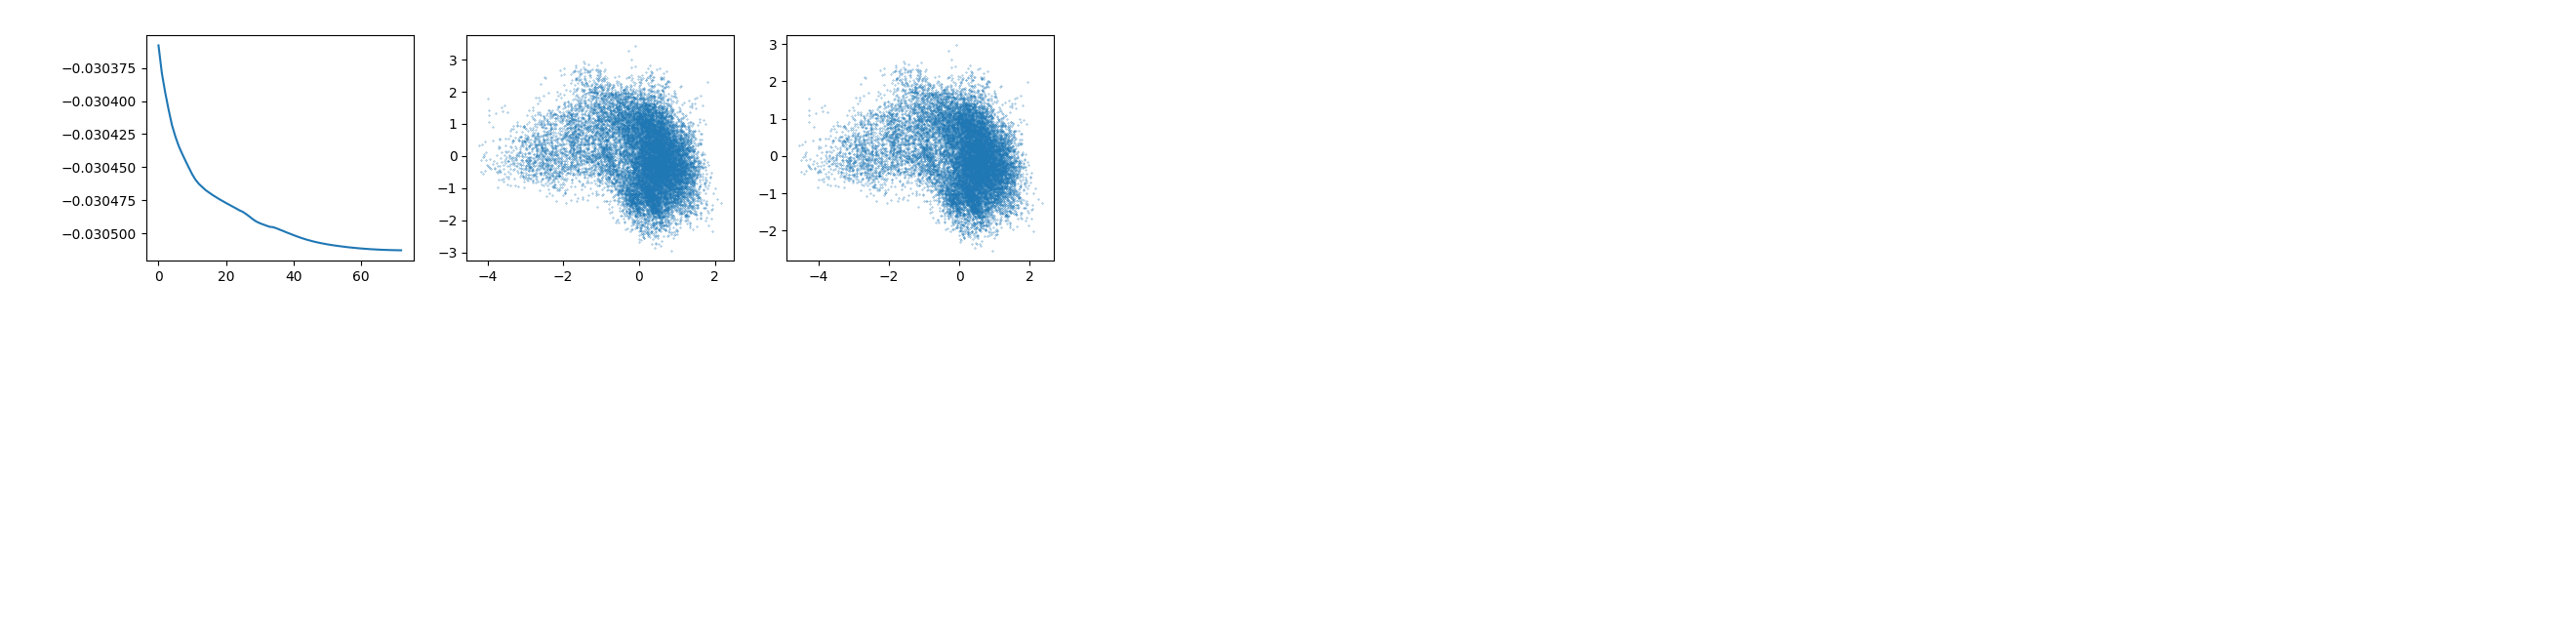

lr changed to: 0.0011725951011387799
step 1 angle: 90.0 loss: -0.030357923358678818 weight change:  0.07072848081588745
step 2 angle: 29.439838409423828 loss: -0.030378952622413635 weight change:  0.044160231947898865
step 3 angle: 46.474029541015625 loss: -0.030393680557608604 weight change:  0.03574785590171814
step 4 angle: 54.79682159423828 loss: -0.03040655329823494 weight change:  0.03374551236629486
step 5 angle: 58.509849548339844 loss: -0.030418213456869125 weight change:  0.026398558169603348
lr changed to: 0.0010553355910249019
step 6 angle: 62.28870391845703 loss: -0.030426781624555588 weight change:  0.020915234461426735
step 7 angle: 11.921321868896484 loss: -0.030434031039476395 weight change:  0.014804137870669365
step 8 angle: 19.953598022460938 loss: -0.03043975867331028 weight change:  0.013124645687639713
step 9 angle: 27.372600555419922 loss: -0.03044513426721096 weight change:  0.012009143829345703
step 10 angle: 35.1135368347168 loss: -0.030450327321887016 weight

In [13]:
%matplotlib notebook

k = int(batch_size*0.16)

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
# ax2 = fig.add_subplot(133, projection='3d')
ax3 = fig.add_subplot(133)

# trace = []
change = 100
W_STOP = 1e-8
d_weigths = torch.zeros(num_of_img)
old_d_weights = torch.zeros([1, num_of_img])
torch_pi = torch.acos(torch.zeros(1)).item() * 2 

# for epoch in range(num_epoch):
step0 = 0
angle_delta = 0
while step0 < num_epoch and change > W_STOP:
# for i in range(1000):
    LOSS = 0
    old_weight = torch.clone(model.W1.weight.data)
    for step, ipt_batch in enumerate(loader):
        model.zero_grad()
        ipt_batch = ipt_batch.to(device)
        
        opt= model.forward(ipt_batch) 
#         neg_batch = my_loss.get_neg_batch(ipt_batch)
#------------------------------sphe2cartesin----------------------------------
        
#---------------------------------------------------------------
#         loss = entropyLoss(opt.permute(1,0), device=device)
#         loss1 = entropy(opt, k=k, dis=1)
#         loss = my_loss(opt, ipt_batch)
#         loss = my_entropy(opt)
#         loss = entropy(opt)
        loss = infonce(opt, ipt_batch)

        loss.backward()
        optimizer.step()
        LOSS+=loss
    d_weigths = model.W1.weight.data - old_weight
    change = norm(d_weigths)**2
    d_weigths = d_weigths.cpu()
    if step > 2:
        angle_delta = torch.arccos(
                    torch.sum(d_weigths * old_d_weights) /
                    (norm(d_weigths) * norm(old_d_weights) + 1e-8)
                ) * 180 / torch_pi
    if angle_delta > 60:
        learning_rate = learning_rate * 0.9
        
        print('lr changed to:', learning_rate)
        
        optimizer.param_groups[0]['lr'] = learning_rate
        old_d_weights = torch.clone(d_weigths)
    elif step == 1:
        old_d_weights = torch.clone(d_weigths)
        
        
        
    LOSS = LOSS.cpu()
    loss_tracker.append(LOSS.detach().numpy()/len(loader.sampler))
    if step0 % 2 == 0:
        
#         index = np.random.randint(0,num_of_img, 2)
        index = [0,1]
        ax.clear()
        ax.plot(loss_tracker[-100:])
        fig.canvas.draw()
    
#         data = model.forward(IPT.T).cpu().detach().numpy()
        data1 = model.forward(IPT.T)
#         data2 = angle2cart(data1).cpu().detach().numpy()
#         data2 = spher2cart(data1).cpu().detach().numpy()
        data1 = data1.cpu().detach().numpy()
        data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
#         data2 = data.cpu().detach().numpy()
        ax1.clear()
        ax1.plot(data1[:, index[0]], data1[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        
#         ax2.clear()
#         ax2.scatter(data2[:,-1], data2[:,-2], data2[:,-3], c = 'r', s=0.1)

# #         ax2.set_xlim3d(-2,2)
# #         ax2.set_ylim3d(-2,2)
# #         ax2.set_zlim3d(-2,2)
#         ax2.set_xlim3d(-10,10)
#         ax2.set_ylim3d(-10,10)
#         ax2.set_zlim3d(-10,10)
        
#         fig.canvas.draw()

        ax3.clear()
        
        ax3.plot(data[:, index[0]], data[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        

    

    step0 += 1
    print('step', step0, 
          'angle:', angle_delta.item(), 
          'loss:', LOSS.detach().numpy()/len(loader.sampler), 
          'weight change: ', change.item(),
         )
    scheduler.step()

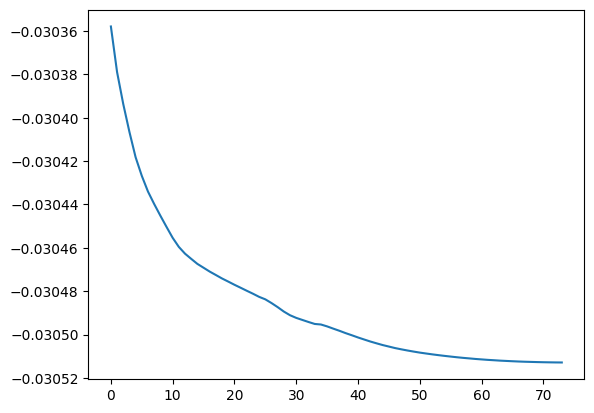

In [14]:
%matplotlib inline
plt.plot(loss_tracker)

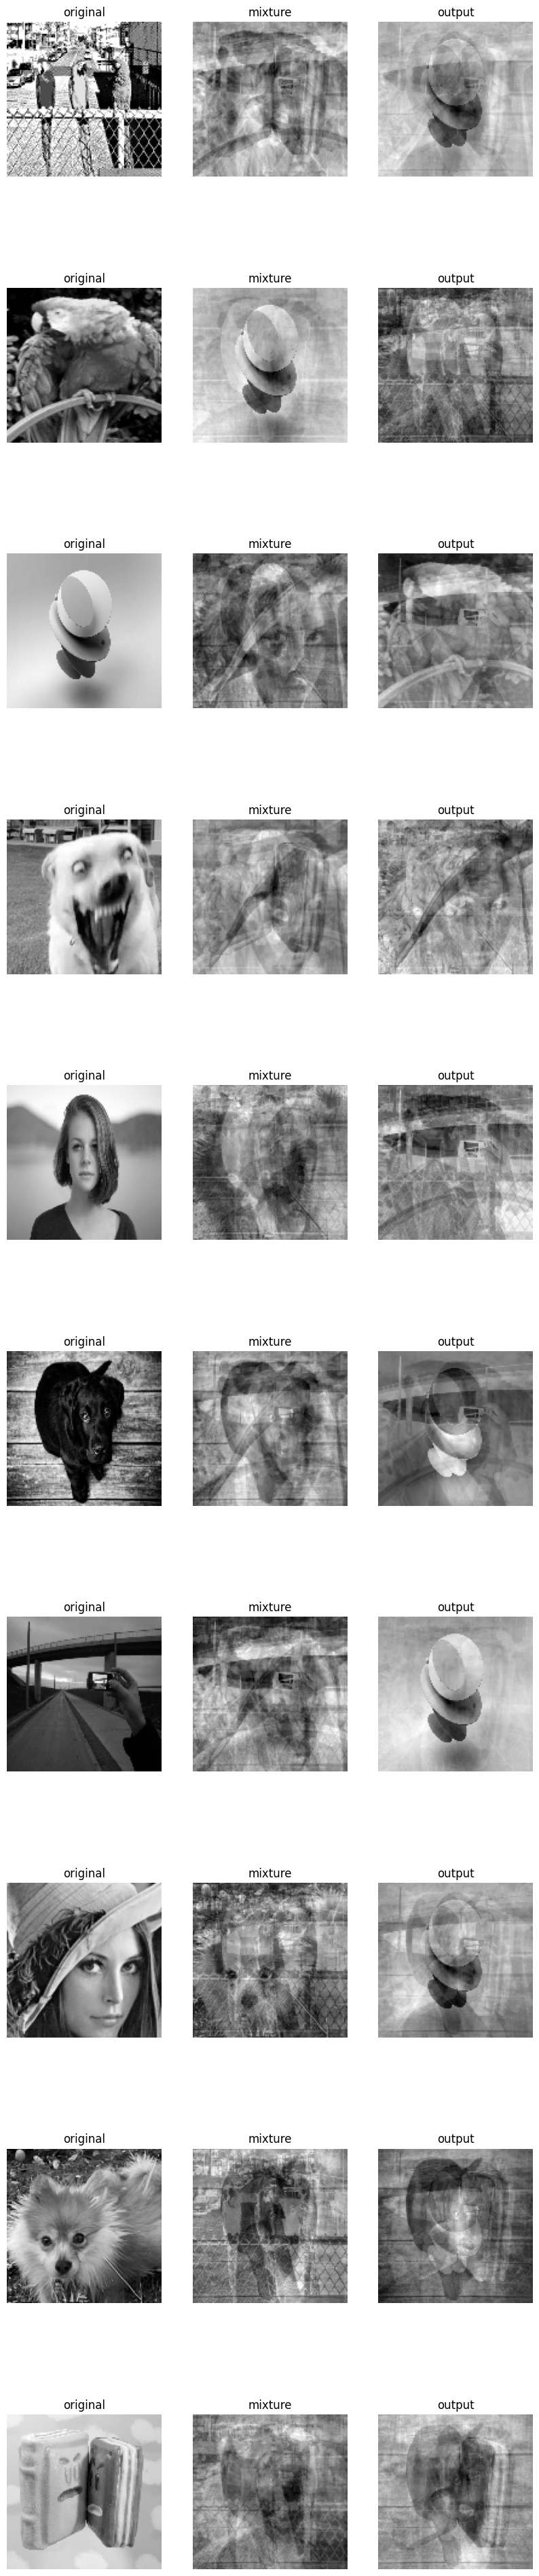

In [15]:
%matplotlib inline

plt.figure(figsize=(10,5*num_of_img))
for i in range(num_of_img):
    plt.subplot(num_of_img, 3, i*3+1)
    plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
    plt.title('original')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+2)
    plt.imshow(np.reshape(x_white[i], (resize,resize)), cmap='gray')
    plt.title('mixture')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+3)
    plt.imshow(np.reshape(data[:, i], (resize,resize)), cmap='gray')
    plt.title('output')
    plt.axis('off')

In [16]:
# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(data2.T[:, i], data2.T[:, j], '.', ms=1)
#         plt.axis('square')

In [17]:
mixer, b, unmixer = ica.ica1(mixture, ncomp=num_of_img, verbose=True)

Whitening data...
x_white shape: 10, 16384
Done.
Running INFOMAX-ICA ...
Beginning ICA training...
Step 59: Lrate 5.4e-06,Wchange 7.2e-07,Angle 105.15
Done.


In [18]:
# %matplotlib inline

# plt.figure(figsize=(10,5*num_of_img))
# for i in range(num_of_img):
#     plt.subplot(num_of_img, 3, i*3+1)
#     plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
#     plt.title('original')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 3, i*3+2)
#     plt.imshow(np.reshape(x_white[i], (resize,resize)), cmap='gray')
#     plt.title('mixture')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 3, i*3+3)
#     plt.imshow(np.reshape(-b[i], (resize,resize)), cmap='gray')
#     plt.title('output')
#     plt.axis('off')

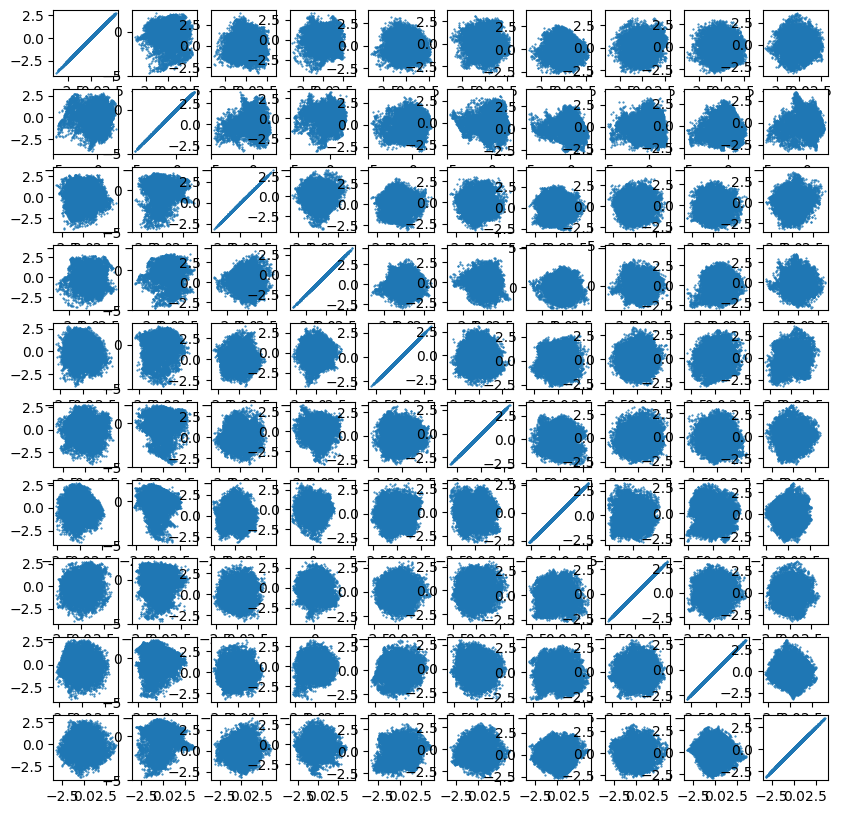

In [19]:
# %matplotlib inline
# # plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # # plt.axis('square')
# plt.figure(figsize=(10,10))
# sub_shape = num_of_img
# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(x_white[i], x_white[j], '.', ms=1)
#         plt.axis('square')

In [20]:
# model = model.cpu()
# IPT = IPT.cpu()
data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
# data = model.forward(IPT.T).cpu().detach().numpy()

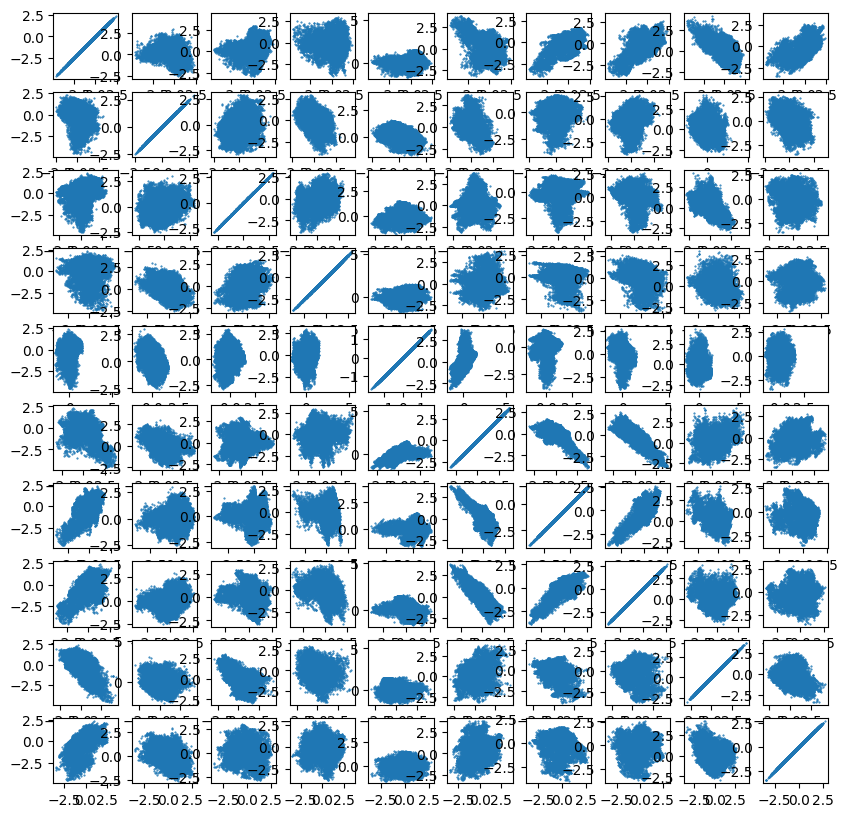

In [21]:
%matplotlib inline
# plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # plt.axis('square')
plt.figure(figsize=(10,10))
sub_shape = num_of_img
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data[:, i], data[:, j], '.', ms=1)
        plt.axis('square')

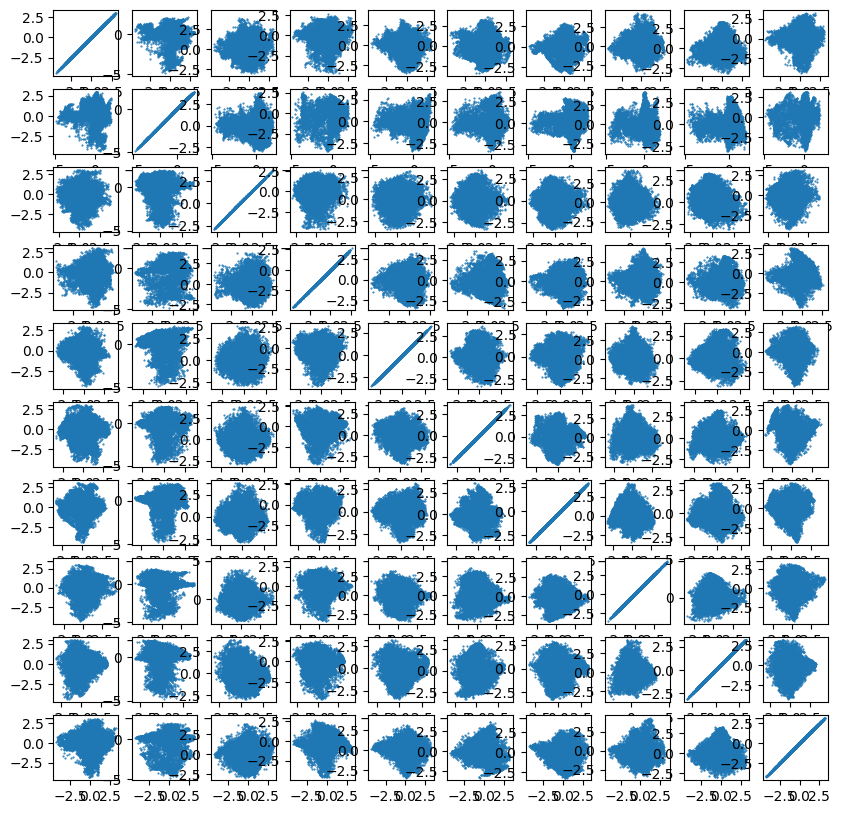

In [22]:
%matplotlib inline
# plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # plt.axis('square')
plt.figure(figsize=(10,10))
sub_shape = num_of_img
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(b[i], b[j], '.', ms=1)
        plt.axis('square')

In [23]:
b.shape

(10, 16384)

In [24]:
data.shape

(16384, 10)

In [25]:
map_k_i = np.corrcoef(data.T, b)
map_k_white = np.corrcoef(data.T, x_white)
map_i_white = np.corrcoef(b, x_white)

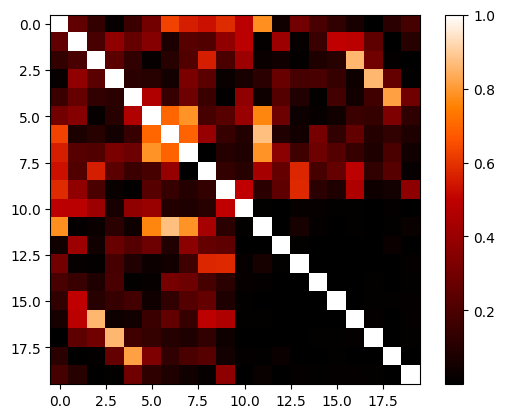

In [26]:
plt.imshow(abs(map_k_i), cmap='gist_heat')
plt.colorbar()

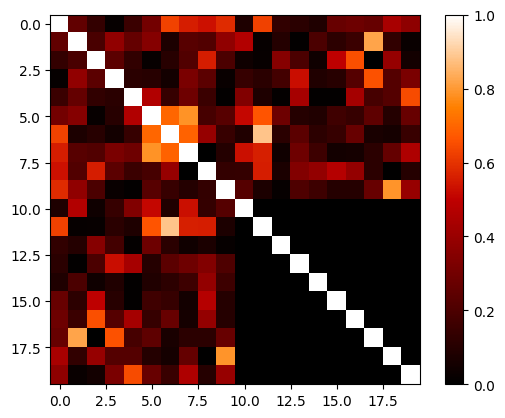

In [27]:
plt.imshow(abs(map_k_white), cmap='gist_heat')
plt.colorbar()

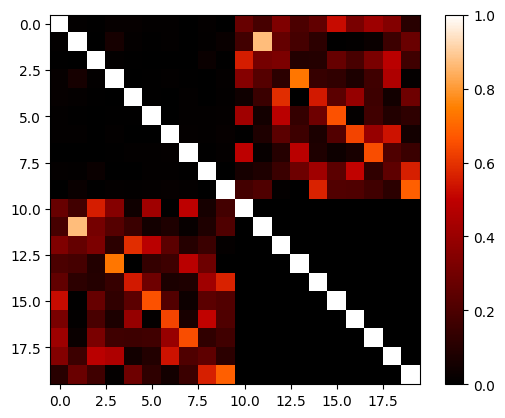

In [28]:
plt.imshow(abs(map_i_white), cmap='gist_heat')
plt.colorbar()